# Average number of tests, false negative rate and false positive rate under different values of the parameters λ<sub>1</sub> and λ<sub>2</sub>

This notebook reproduces Fig. 3 and Tables S3-S10.

In [1]:
import os
os.chdir("../")

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import scipy
import seaborn as sns
import glob
import json
from src import utils
from src.utils import get_fig_dim
from IPython.display import clear_output
import matplotlib.pyplot as plt
import docx

sns.set_theme(context='paper', style='ticks', font_scale=1)

Set the values of sensitivity s<sub>e</sub> and specificity s<sub>p</sub>.

In [6]:
se=0.7
sp=0.97

In [7]:
name="lambdas"
width_pt = 469
palette = sns.color_palette('husl', 6)
type_dict = {
    'N' : int, 
    'false_negatives' : int,
    'false_positives' : int,
    'k' : float,
    'lambda_1' : float,
    'lambda_2' : float,
    'method' : str,
    'num_of_infected' : int,
    'num_of_tests' : int,
    # 'avg_group_size' : float,
    'r' : float,
    'score' : float,
    'se' : float,
    'sp' : float,
    'seed' : int
}

In [8]:
files = glob.glob("./outputs/{name}_*_se_{se}_sp_{sp}_*.json".format(name=name, se=se, sp=sp))

dicts = []
for fl_id, fl in enumerate(files):
    clear_output(wait=True)
    print('Reading file ' + str(fl_id+1)+'/'+str(len(files)))
    with open(fl,"r") as f:
        js = json.load(f)
        sizes = []
        for group_id in js['groups']:
            sizes.append(int(js['groups'][group_id]))

        # avg_group_size = np.mean(sizes)
        sizes = sorted(sizes, reverse=True)
        sizes_str = '|'.join([str(x) for x in sizes])

        
        for seed in js['seeds']:
            seed_js = js.copy()
            seed_js.pop('seeds', None)
            seed_js.pop('groups', None)    
            seed_js = seed_js | js['seeds'][seed]
            seed_js['seed']=seed
            seed_js['group_sizes'] = sizes_str

            dicts.append(seed_js)

input_df = pd.DataFrame(dicts)

Reading file 2001/2001


The following block stores the results under the given sensitivity and specificity values into a dataframe and saves the dataframe in the 'temp-outputs' directory. Execute it and repeat for all combinations of sensitivity s<sub>e</sub> and specificity s<sub>p</sub>. This is done to avoid excessive memory usage by reading all output files at once.

In [9]:
total_df = input_df.astype(type_dict) # Fix types
total_df = total_df.rename(columns={"method": "Method", "score": "Score", "false_negatives": "FNs", "false_positives": "FPs",
                                    "num_of_tests": "Number of tests", "lambda_1" : "lambda 1", "lambda_2" : "lambda 2",
                                    "exp_tests" : "Expected tests", "group_sizes" : "Group sizes"}) # Rename columns
total_df = total_df.replace({'binomial': 'Dorfman', 'negbin': 'Neg.Bin.'}) # Rename methods
total_df['False Negative rate'] = total_df['FNs']/total_df['num_of_infected']*100
total_df['False Negative rate'] = total_df['False Negative rate'].replace(np.inf, np.nan).fillna(0)
total_df['False Positive rate'] = total_df['FPs']/(total_df['N']-total_df['num_of_infected'])*100
total_df['False Positive rate'] = total_df['False Positive rate'].replace(np.inf, np.nan).fillna(0)

FN_df=total_df[total_df['lambda 2']==0.0]
FP_df=total_df[total_df['lambda 1']==0.0]
FN_df = FN_df.groupby(by=['Group sizes']).mean().reset_index()[['Group sizes', 'Number of tests', 'False Negative rate', 'False Positive rate', 'FNs', 'FPs', 'lambda 1']]
FP_df = FP_df.groupby(by=['Group sizes']).mean().reset_index()[['Group sizes', 'Number of tests', 'False Negative rate', 'False Positive rate', 'FNs', 'FPs', 'lambda 2']]

FN_df.to_pickle("temp-outputs/FN_df_se_{se}_sp_{sp}.pkl".format(se=se, sp=sp))
FP_df.to_pickle("temp-outputs/FP_df_se_{se}_sp_{sp}.pkl".format(se=se, sp=sp))

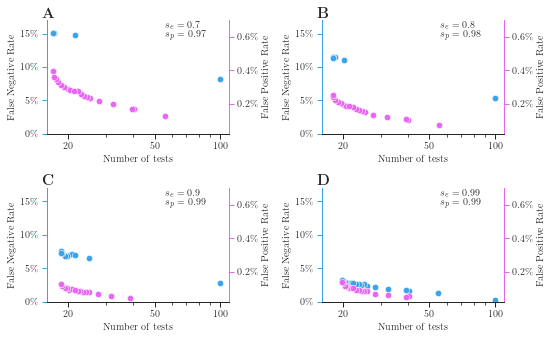

In [11]:
utils.latexify(font_size=10)

fig_height, fig_aspect = get_fig_dim(width_pt, fraction=0.6)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(2*fig_height*fig_aspect,2*fig_height))
secondary_axes = [ax.twinx() for ax in axes.flatten()]

pairs = [(0.7, 0.97), (0.8, 0.98), (0.9, 0.99), (0.99, 0.99)]
letters = [r'\textbf{A}', r'\textbf{B}', r'\textbf{C}', r'\textbf{D}']
for ind, ax in enumerate(axes.flatten()):
    
    ax2 = secondary_axes[ind]
    se = pairs[ind][0]
    sp = pairs[ind][1]
    FN_df = pd.read_pickle("temp-outputs/FN_df_se_{se}_sp_{sp}.pkl".format(se=se, sp=sp))
    FP_df = pd.read_pickle("temp-outputs/FP_df_se_{se}_sp_{sp}.pkl".format(se=se, sp=sp))

    marker_size = 40
    p = sns.scatterplot(data=FN_df, x="Number of tests", y="False Negative rate", ax=ax, color=palette[4], s=marker_size)#, label=r'$\lambda_2 = 0$')
    p2 = sns.scatterplot(data=FP_df, x="Number of tests", y="False Positive rate", ax=ax2, color=palette[5], s=marker_size)#, label=r'$\lambda_1 = 0$')
    sns.despine(top=True, right=False)

    ax.set_xlim([16,110])
    ax.set_ylim([0,17])
    ax2.set_ylim([0.02,0.7])
    ax.set_xscale('log')
    ax.set_xticks([20, 50, 100])
    ax.set_xticklabels([20, 50, 100])
    plt.setp(ax.get_xminorticklabels(), visible=False)
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter(decimals=0))
    ax2.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter(decimals=1))

    ax2.spines['left'].set_color(palette[4])
    ax2.spines['right'].set_color(palette[5])
    ax.tick_params(axis='y', color=palette[4])
    ax2.tick_params(axis='y', color=palette[5])

    ax.set_xlabel('Number of tests')
    ax.set_ylabel('False Negative Rate')
    ax2.set_ylabel('False Positive Rate')

    ax.text(x=0.01, y=1, s=letters[ind], size=15, transform = ax.transAxes, horizontalalignment='center', verticalalignment='bottom')
    ax.text(x=0.65, y=1, s=r'$s_e={se}$'.format(se=se)+'\n'+r'$s_p={sp}$'.format(sp=sp), transform = ax.transAxes, horizontalalignment='left', verticalalignment='top')
    
fig.tight_layout()
fig.savefig('figures/sci-adv-fig3.pdf'.format(ver=ind))


Set the values of sensitivity s<sub>e</sub> and specificity s<sub>p</sub> to replicate the contents of Tables S3-S10. Uncomment the previous to last line for results while varying λ<sub>1</sub> and the last line for results while varying λ<sub>2</sub>. The resulting table is saved in the 'temp.docx' file in the 'temp-outputs' directory.

In [14]:
se=0.99
sp=0.99

to_docx = pd.read_pickle("temp-outputs/FN_df_se_{se}_sp_{sp}.pkl".format(se=se, sp=sp))
# to_docx = pd.read_pickle("temp-outputs/FP_df_se_{se}_sp_{sp}.pkl".format(se=se, sp=sp))

In [15]:
to_docx = to_docx.sort_values(by=['Number of tests'])[['Number of tests', 'False Negative rate', 'False Positive rate']]
to_docx = to_docx.round(2)
try:
  os.remove("temp-outputs/temp.docx")
except:
  None
doc = docx.Document()
doc.save('temp-outputs/temp.docx')

t = doc.add_table(to_docx.shape[0]+1, to_docx.shape[1])

for j in range(to_docx.shape[-1]):
    t.cell(0,j).text = to_docx.columns[j]

for i in range(to_docx.shape[0]):
    for j in range(to_docx.shape[-1]):
        t.cell(i+1,j).text = str(to_docx.values[i,j])

# save the doc
doc.save('temp-outputs/temp.docx')